In [1]:
from interaction_inference import simulation
from interaction_inference import correlation
from interaction_inference import optimization
from interaction_inference import dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import tqdm

In [2]:
rng = np.random.default_rng()

# $X_{1}$ $X_{2}$ $X_{3}$ Investigation

## Simulation

In [3]:
# settings
rate = 5
int_str = 5
cells = 1000

# dataframes
counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(3)], columns=[f"Cell-{j}" for j in range(cells)])

# Set reaction rate parameters
params = {
    'k_tx_1': rate,
    'k_tx_2': rate,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': int_str
}

# simulate (x1, x2) interacting sample from model
x1_x2 = simulation.gillespie_birth_death(params, cells)

# split into x1, x2
x1 = [x[0] for x in x1_x2]
x2 = [x[1] for x in x1_x2]

# simulate x3 independent sample
x3 = rng.poisson(params['k_tx_1'], size=cells)

# create (x1, x3), (x2, x3) pairs
x1_x3 = list(zip(x1, x3))
x2_x3 = list(zip(x2, x3))

# store counts
counts_df.iloc[0] = x1_x2
counts_df.iloc[1] = x1_x3
counts_df.iloc[2] = x2_x3

# construct dataset object
data = dataset.Dataset("X1X2X3")

# store information
data.count_dataset = counts_df
data.cells = cells
data.gene_pairs = 3
data.beta = np.array([1.0 for j in range(cells)])

100%|██████████| 3/3 [00:00<00:00, 39.32it/s]


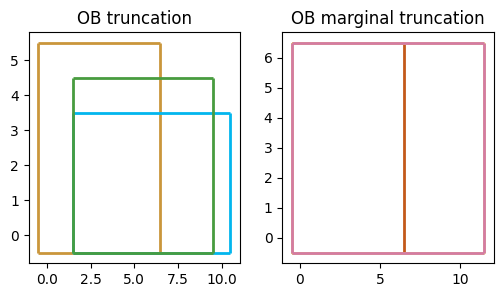

100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


In [4]:
data.compute_moments(tqdm_disable=False)
data.compute_probabilities(display=True, tqdm_disable=False)
data.compute_fm(tqdm_disable=False)

## Single sample feasibility

For each sample $x_{1}$, $x_{2}$, $x_{3}$ use marginal probability and CME to test feasibility of birth-death model

In [5]:
constraints = [
    "marginal_probability_1",
    "marginal_CME_1",
    "k_deg_1"
]

print("X1, X1, X2")

single_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

constraints = [
    "marginal_probability_2",
    "marginal_CME_2",
    "k_deg_2"
]

print("X2, X3, X3")

single_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

X1, X1, X2
Optimization status: INFEASIBLE
Runtime: 0.03399991989135742
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.007999897003173828
X2, X3, X3
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.017000198364257812
Optimization status: OPTIMAL
Runtime: 0.0


Birth death feasibility tests correctly identify that $X_{1}$ and $X_{2}$ do not follow a birth-death model (INFEASIBLE) but $X_{3}$ does (OPTIMAL)

In [6]:
constraints = [
    "downsampled_marginal_probability_1",
    "downsampled_marginal_CME_1",
    "k_deg_1"
]

print("X1, X1, X2")

single_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

constraints = [
    "downsampled_marginal_probability_2",
    "downsampled_marginal_CME_2",
    "k_deg_2"
]

print("X2, X3, X3")

single_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

X1, X1, X2
Optimization status: INFEASIBLE
Runtime: 0.009000062942504883
Optimization status: INFEASIBLE
Runtime: 0.002000093460083008
Optimization status: INFEASIBLE
Runtime: 0.0
X2, X3, X3
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.0


Downsampled birth death feasibility tests produce the same results (However, note we are working at 100% capture efficiency)

## Independent pair feasibility

In [7]:
constraints = [
    "marginal_probability_1",
    "marginal_probability_2",
    "marginal_CME_1",
    "marginal_CME_2",
    "k_deg_1",
    "k_deg_2"
]


print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0


Using marginal constraints produces identical results to AND operation on single sample tests (as this is what is happening in constraints)

(Downsampled marginal constraints also produce the same result)

In [9]:
constraints = [
    "probability",
    "CME",
    "factorization",
    "k_reg",
    "k_deg_1",
    "k_deg_2"
]


print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 1.1619999408721924
Optimization status: INFEASIBLE
Runtime: 0.9830000400543213


Using joint constraints (with independence assumed) **generally** produces the same results, But, not always and perhaps only for sufficiently high interaction strength as joint constraints are weaker than marginals e.g. in the results above it is not uncommon for a pair with a gene affected by interaction to be feasible

(NOTE: original scale optimization with joint constraints is only possible for (near) 100% capture efficiency, due to poor time and memory scaling of the method)

Overall the independent birth-death feasibility tests show that if **at least one** sample in the pair is affected by sufficiently high interaction then the model is infeasible. However, it is more efficient and reliable to use marginal constraints to test individual samples for feasiblity, rather than pairs of samples / using joint information.

## Interacting pair feasibility

In [51]:
constraints = [
    "joint_probability",
    "CME",
    "k_deg_1"
]

print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: OPTIMAL
Runtime: 0.019999980926513672
Optimization status: OPTIMAL
Runtime: 0.8300001621246338
Optimization status: OPTIMAL
Runtime: 0.8589999675750732


Interacting birth-death feasibility test is feasible for all pairs.

This is expected for $(X_{1}, X_{2})$ as these truly follow an interacting birth death model, but for the pairs $(X_{1}, X_{3})$ and $(X_{2}, X_{3})$ only one the samples is affected by interaction: either the constraints are too weak to identify this, or the model is simply general enough that these pairs are still consistent with it.

In [11]:
constraints = [
    "downsampled_probability",
    "downsampled_CME",
    "k_deg_1"
]

print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: OPTIMAL
Runtime: 0.018000125885009766
Optimization status: OPTIMAL
Runtime: 0.020999908447265625
Optimization status: OPTIMAL
Runtime: 0.03300023078918457


Downsampled feasibility test of interacting birth death model also feasible for all pairs. However, need further tests to assess if the CME discrepancies identified (0 not in confidence interval of some equations) will cause higher false positive rates (or not) for this feasibility test.

## Moment test

In [52]:
constraints = [
    "dummy_moment"
]

print("(X1, X2), (X1, X3), (X2, X3)")

pair_sample = optimization.Optimization(data, constraints, tqdm_disable=True)

(X1, X2), (X1, X3), (X2, X3)
Optimization status: INFEASIBLE
Runtime: 0.0010001659393310547
Optimization status: OPTIMAL
Runtime: 0.003999948501586914
Optimization status: OPTIMAL
Runtime: 0.00599980354309082


Moments correctly identify the interaction present in the 1st pair and lack of in the 2nd and 3rd pairs, even though these pairs have one sample affected by strong interaction.

## Correlation test

In [54]:
corr = correlation.Correlation(data, tqdm_disable=True)

sample 0 p-value: 9.994851629150251e-47
sample 1 p-value: 0.5556251284148317
sample 2 p-value: 0.8163599256374103


Correlation test performs the same as the moments, correctly classifying the pairs